In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import HierlmannVisapyEmulationProbe
import matplotlib.pyplot as plt
import h5py
import numpy as np

np.random.seed(0)

In [2]:
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data
import random

torch.cuda.set_device(0)
torch.manual_seed(0)

In [3]:
# raw data location
data_path = 'visapy_data.npy'

In [4]:
# detection parameters
to_localize = True
cutout_start = 14
cutout_end = 36
threshold = 15
file_directory = 'results/'
file_name = 'ProcessedSpikes_visapy'

In [5]:
Probe = HierlmannVisapyEmulationProbe(data_path)
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, save_all=True)

File size: 122400102
Number of channels: 102


# Data Prepping and Split

In [6]:
H.DetectFromRaw()
H.LoadDetected()

# Sampling rate: 32000
# Localization On
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 102
# Analysing frames: 1200001, Seconds:37.50003125
# Frames before spike in cutout: 32
# Frames after spike in cutout: 70
# tcuts: 44 59
# tInc: 50000
# Analysing 50000 frames; from -44 to 50059
# Analysing 50000 frames; from 49956 to 100059
# Analysing 50000 frames; from 99956 to 150059
# Analysing 50000 frames; from 149956 to 200059
# Analysing 50000 frames; from 199956 to 250059
# Analysing 50000 frames; from 249956 to 300059
# Analysing 50000 frames; from 299956 to 350059
# Analysing 50000 frames; from 349956 to 400059
# Analysing 50000 frames; from 399956 to 450059
# Analysing 50000 frames; from 449956 to 500059
# Analysing 50000 frames; from 499956 to 550059
# Analysing 50000 frames; from 549956 to 600059
# Analysing 50000 frames; from 599956 to 650059
# Analysing 50000 frames; from 649956 to 700059
# Analysing 50000 frames; from 699956 to 750

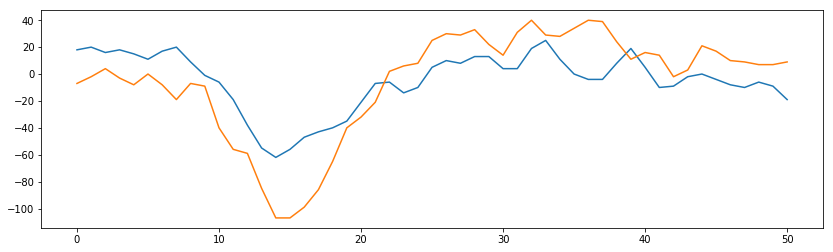

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(14,4))
for i in [0, 1]:
    plt.plot(H.spikes['Shape'][i])
plt.show()

In [8]:
length = H.spikes['Shape'][0].shape[0]
total_sigs = H.spikes['Shape'].shape[0]

electrode_data = np.zeros([total_sigs, length])
list_of_sigs = np.random.choice(total_sigs, total_sigs, replace=False)

for i in list_of_sigs:
    electrode_data[i, :] = H.spikes['Shape'][i]
print(electrode_data.shape)

(32826, 51)


In [9]:
# min_val = np.amin(electrode_data)
# max_val = np.amax(electrode_data)
# electrode_data = electrode_data/(max_val - min_val)
# electrode_data = electrode_data - np.amin(electrode_data)

# print(np.amin(electrode_data), np.amax(electrode_data))

In [10]:
train_lim = int(0.8*electrode_data.shape[0])
electrode_data_train = electrode_data[:train_lim, :]
electrode_data_test = electrode_data[train_lim:, :]

print("Training Datasize:", electrode_data_train.shape)
print("Test Datasize:", electrode_data_test.shape)

Training Datasize: (26260, 51)
Test Datasize: (6566, 51)


# Helper Functions

In [123]:
def find_scaled_mse(original, recons, params):
    mse = []
    for i in range(original.shape[0]):
        se = (original[i, :] - recons[i, :])**2
        se = se/np.std(original[i, :])
        mse.append(np.mean(se))
    print(params, np.median(mse))
    mse = np.array(mse)
    return mse

In [12]:
# dict_of_outputs = {'AE_2': [<np.array>], 'AE_4':[<np.array>], ... 'PCA':[<np.array>], 'Original': [<np.array>]}

def plot_correlation(dict_of_outputs):
    plt.figure(figsize=(14,8))

    keys = list(dict_of_outputs.keys())
    vals = list(dict_of_outputs.values())
    
    size = len(keys)/2 *100 + 20
    
    for i in range(len(keys)):
        plt.subplot(size+i)
        plt.scatter(electrode_data_test, vals[i], s=0.5)
        plt.title(str(keys[i]))
    plt.show()

In [13]:
# dict_of_outputs = {'AE_2': [<list>], 'AE_4':[<list>], ... 'PCA':[<list>], 'Original': [<list>]}

def gen_boxplots(dict_of_outputs):
    fig = plt.figure(1, figsize=(7,5))
    
    keys = list(dict_of_outputs.keys())
    vals = list(dict_of_outputs.values())
    
    ax = fig.add_subplot(111)
    ax.boxplot(vals, showfliers=False, notch=True)
    ax.grid()
    ax.set_xticklabels(keys)
    plt.show()

In [14]:
# dict_of_outputs = {'AE_2': [<np.array>], 'AE_4':[<np.array>], ... 'PCA':[<np.array>], 'Original': [<np.array>]}

def find_correlation_coeff(dict_of_outputs, plot = True):
    
    keys = list(dict_of_outputs.keys())
    vals = list(dict_of_outputs.values())
    corrs = {}
    for i in range(len(keys)):
        corrs[keys[i]] = [np.corrcoef(electrode_data_test[j],vals[i][j])[0,1] 
                             for j in range(electrode_data_test.shape[0])]
    holder = []
    for i in keys:
        print(i, np.median(corrs[i]))
        holder.append((i, np.median(corrs[i])))
    if plot:
        gen_boxplots(corrs)
    else:
        return holder

In [15]:
def comp_pca(components):
    pca = PCA(n_components=components)
    pca.fit(electrode_data_train)
    e_data_pca = pca.transform(electrode_data_test)
    e_data_proj = pca.inverse_transform(e_data_pca)
    return e_data_proj

In [101]:
def get_network_output(model, embedding):
    enc_final = np.zeros([electrode_data_test.shape[0], embedding])
    out_final = np.zeros([electrode_data_test.shape[0], 51])
    
    min_batch = 3
    
    for i in range(electrode_data_test.shape[0]):
        data = electrode_data_test[i, :]
        data = torch.from_numpy(data).float()

        enc, o = model.forward(data.view(-1, min_batch, 1))
        o = (o.data).cpu().numpy()
        enc = (enc.data).cpu().numpy()

        #enc_final[i, :] = enc[:]
        out_final[i, :] = o[:]
    
    return enc_final, out_final

# DEFINING MODELS

In [102]:
random.seed(0)

def train_ae(model, input_data, criterion, optimizer, epoch_range,  batch_size, min_batch):
    losses = []
    mdl_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('TOTAL PARAMETERS FOR MODEL:', mdl_total_params)
    
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, input_data.shape[0]), batch_size)
        for i, feats in enumerate(selected):
            x = input_data[feats, :]
            x = torch.from_numpy(x).float().cuda()
            #---------FORWARD------------#
            enc, out = model.forward(x.view(-1, min_batch, 1))
            out = torch.tensor(out).float().cuda()
            loss = criterion(out, x)
            #---------BACKWARD------------#
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.data[0])
        if num_epoch%10 == 0:
            print('epoch [{}/{}], loss:{:.8f}, avg:{:.8f}'.format(num_epoch + 1, epoch_range, 
                                                              loss.data[0], sum(losses[-10:])/len(losses[-10:])))
    return enc, out, losses

def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)

## Simple LSTM1 - LIN

In [109]:
class lstm_autoencoder3(nn.Module):
    def __init__(self, input_size, batch_size, embedding_size):
        super(lstm_autoencoder3, self).__init__()
        if input_size%batch_size != 0:
            print('Input size dimensions not divisible by sequence length')
            return None
        self.activation_layer = nn.ELU()
        
        hid = 20
        
        first_lin_size = hid*input_size
        
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=hid, num_layers=1)
        self.lin1 = nn.Linear(first_lin_size, embedding_size)
        
        self.lin2 = nn.Linear(embedding_size, first_lin_size)
        self.lin3 = nn.Linear(first_lin_size, input_size)
    
    def forward(self, x, hidden=None):
        out, _ = self.lstm1(x, hidden)
        out = self.flatten_input(out)
        enc = self.lin1(out)
        out = self.lin2(enc)
        out = self.activation_layer(out)
        dec = self.lin3(out)
        return enc, dec
    
    def flatten_input(self, data):
        data = data.view(-1)
        return data

In [110]:
# Training the AE for encoder1

# Training for 4 embeddings

epoch_range = 5000
batch_size = 300
learning_rate = 0.00001
min_batch = 1

# embedding_size = 4

# ae_14 = lstm_autoencoder3(length, min_batch, embedding_size).cuda()
# ae_14.apply(init_weights)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     ae_14.parameters(), lr=learning_rate, weight_decay=0.001)

# enc, out, losses_14 = train_ae(ae_14, electrode_data_train, criterion, optimizer, epoch_range, batch_size, min_batch)

# Training for 2 embeddings

embedding_size = 2

ae_12 = lstm_autoencoder3(length, min_batch, embedding_size).cuda()
ae_12.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_12.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_12 = train_ae(ae_12, electrode_data_train, criterion, optimizer, epoch_range, batch_size, min_batch)

# Saving relevant files

# Saving Losses
# np.save('models/lstm_models/losses_1_4', np.array(losses_14))
np.save('models/lstm_models/losses_1_2', np.array(losses_12))


# Saving Models
# torch.save(ae_14, 'models/lstm_models/ae_1_4.pt') #Saving the autoencoder model
torch.save(ae_12, 'models/lstm_models/ae_1_2.pt') #Saving the autoencoder model

TOTAL PARAMETERS FOR MODEL: 59013
epoch [1/5000], loss:2678.39306641, avg:1661.27282715
epoch [11/5000], loss:1127.78845215, avg:688.46820068
epoch [21/5000], loss:310.98504639, avg:400.09994507
epoch [31/5000], loss:199.08758545, avg:335.92480469
epoch [41/5000], loss:98.07118988, avg:207.64506531
epoch [51/5000], loss:110.64595795, avg:381.48587036
epoch [61/5000], loss:169.10104370, avg:288.74191284
epoch [71/5000], loss:187.37211609, avg:294.16760254
epoch [81/5000], loss:322.74200439, avg:213.68882751
epoch [91/5000], loss:101.27706909, avg:195.98796082
epoch [101/5000], loss:150.84704590, avg:356.32919312
epoch [111/5000], loss:150.13803101, avg:218.21878052
epoch [121/5000], loss:161.31266785, avg:219.94262695
epoch [131/5000], loss:509.07470703, avg:212.26611328
epoch [141/5000], loss:347.69024658, avg:246.52432251
epoch [151/5000], loss:146.10946655, avg:166.93273926
epoch [161/5000], loss:340.05609131, avg:158.81376648
epoch [171/5000], loss:160.33787537, avg:121.57122040
epo

epoch [1521/5000], loss:372.17379761, avg:146.50090027
epoch [1531/5000], loss:94.66699219, avg:117.48833466
epoch [1541/5000], loss:60.55741501, avg:113.32927704
epoch [1551/5000], loss:98.26861572, avg:86.93398285
epoch [1561/5000], loss:84.79547882, avg:97.13885498
epoch [1571/5000], loss:319.41726685, avg:167.52798462
epoch [1581/5000], loss:176.72010803, avg:134.10758972
epoch [1591/5000], loss:99.72851562, avg:166.27558899
epoch [1601/5000], loss:66.41584015, avg:86.73491669
epoch [1611/5000], loss:100.77381897, avg:100.65164948
epoch [1621/5000], loss:102.09555817, avg:95.84173584
epoch [1631/5000], loss:103.93986511, avg:112.42119598
epoch [1641/5000], loss:62.93721390, avg:95.38919830
epoch [1651/5000], loss:61.40330887, avg:90.72045135
epoch [1661/5000], loss:119.47291565, avg:114.82863617
epoch [1671/5000], loss:109.71833038, avg:198.64616394
epoch [1681/5000], loss:75.90015411, avg:121.23455048
epoch [1691/5000], loss:526.60162354, avg:201.50553894
epoch [1701/5000], loss:9

epoch [3031/5000], loss:181.50738525, avg:109.21315002
epoch [3041/5000], loss:263.10565186, avg:124.18955231
epoch [3051/5000], loss:111.55853271, avg:80.65525055
epoch [3061/5000], loss:91.37236023, avg:86.01622772
epoch [3071/5000], loss:225.01286316, avg:104.21333313
epoch [3081/5000], loss:73.31465149, avg:110.08984375
epoch [3091/5000], loss:98.38407898, avg:99.98271942
epoch [3101/5000], loss:57.09613419, avg:125.55419159
epoch [3111/5000], loss:78.45449066, avg:181.24090576
epoch [3121/5000], loss:101.94248199, avg:105.41438293
epoch [3131/5000], loss:129.95799255, avg:123.08535004
epoch [3141/5000], loss:286.52688599, avg:127.10915375
epoch [3151/5000], loss:110.62474823, avg:95.88924408
epoch [3161/5000], loss:126.94835663, avg:104.38557434
epoch [3171/5000], loss:69.64777374, avg:133.52940369
epoch [3181/5000], loss:112.19911957, avg:126.23398590
epoch [3191/5000], loss:285.74227905, avg:141.71653748
epoch [3201/5000], loss:130.45512390, avg:116.81638336
epoch [3211/5000], l

epoch [4541/5000], loss:140.92996216, avg:102.51462555
epoch [4551/5000], loss:82.79526520, avg:97.46998596
epoch [4561/5000], loss:214.91864014, avg:105.56280518
epoch [4571/5000], loss:47.71273804, avg:80.50494385
epoch [4581/5000], loss:464.88415527, avg:141.20692444
epoch [4591/5000], loss:127.22734833, avg:149.14384460
epoch [4601/5000], loss:120.83994293, avg:130.07743835
epoch [4611/5000], loss:68.64937592, avg:119.68520355
epoch [4621/5000], loss:84.29917908, avg:137.94366455
epoch [4631/5000], loss:175.40364075, avg:116.73061371
epoch [4641/5000], loss:62.53649521, avg:92.57659912
epoch [4651/5000], loss:349.65475464, avg:127.98052216
epoch [4661/5000], loss:86.53379822, avg:148.92770386
epoch [4671/5000], loss:351.68524170, avg:159.43635559
epoch [4681/5000], loss:127.81407928, avg:116.29625702
epoch [4691/5000], loss:86.37568665, avg:97.98182678
epoch [4701/5000], loss:95.71826935, avg:134.69728088
epoch [4711/5000], loss:192.51960754, avg:102.10575867
epoch [4721/5000], los

In [111]:
ae_1 = torch.load('models/lstm_models/ae_1_2.pt', map_location=lambda storage, loc: storage)
#ae_2 = torch.load('models/lstm_models/ae_1_4.pt', map_location=lambda storage, loc: storage)

AE 0.9476678794638482
PCA 0.9483949747235514


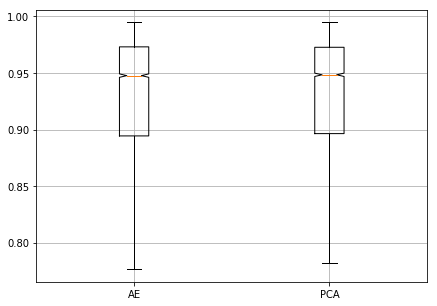

In [112]:
_, out_ae = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'AE': out_ae, 'PCA': out_pca}
find_correlation_coeff(d)

PCA 0.10322112967762259
AE 0.1210366414860671


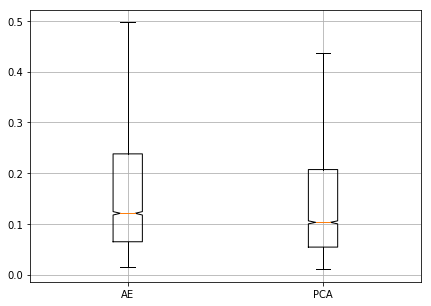

In [113]:
pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse})

# LSTM2- LIN

TOTAL PARAMETERS FOR MODEL: 62373
epoch [1/5000], loss:1579.64855957, avg:1718.74938965
epoch [11/5000], loss:1053.85876465, avg:631.28302002
epoch [21/5000], loss:291.77850342, avg:425.55590820
epoch [31/5000], loss:180.61033630, avg:251.98083496
epoch [41/5000], loss:82.41301727, avg:282.71340942
epoch [51/5000], loss:105.32730103, avg:321.37429810
epoch [61/5000], loss:272.46307373, avg:249.70564270
epoch [71/5000], loss:204.45576477, avg:250.97595215
epoch [81/5000], loss:363.70077515, avg:220.32237244
epoch [91/5000], loss:190.22204590, avg:196.92251587
epoch [101/5000], loss:95.00867462, avg:195.50917053
epoch [111/5000], loss:90.57234955, avg:214.97306824
epoch [121/5000], loss:201.95124817, avg:142.09007263
epoch [131/5000], loss:232.23287964, avg:167.71250916
epoch [141/5000], loss:114.75950623, avg:184.70170593
epoch [151/5000], loss:93.59633636, avg:181.61672974
epoch [161/5000], loss:185.70863342, avg:186.39213562
epoch [171/5000], loss:219.94917297, avg:233.43261719
epoch 

epoch [1531/5000], loss:149.19128418, avg:155.53608704
epoch [1541/5000], loss:151.23526001, avg:147.01843262
epoch [1551/5000], loss:38.72188950, avg:109.04369354
epoch [1561/5000], loss:78.27602386, avg:143.36260986
epoch [1571/5000], loss:82.32244873, avg:79.17858124
epoch [1581/5000], loss:189.01673889, avg:154.68287659
epoch [1591/5000], loss:295.80133057, avg:116.21582031
epoch [1601/5000], loss:74.17391205, avg:247.62199402
epoch [1611/5000], loss:67.80134583, avg:108.13490295
epoch [1621/5000], loss:63.84952164, avg:160.07321167
epoch [1631/5000], loss:345.04327393, avg:114.19966125
epoch [1641/5000], loss:50.09157181, avg:94.21542358
epoch [1651/5000], loss:44.24972153, avg:94.32343292
epoch [1661/5000], loss:202.12303162, avg:113.58669281
epoch [1671/5000], loss:205.62205505, avg:152.12651062
epoch [1681/5000], loss:60.02959442, avg:177.51042175
epoch [1691/5000], loss:66.98696899, avg:127.16487122
epoch [1701/5000], loss:65.67081451, avg:140.89720154
epoch [1711/5000], loss:

epoch [3041/5000], loss:102.55362701, avg:142.93759155
epoch [3051/5000], loss:155.05523682, avg:192.24198914
epoch [3061/5000], loss:96.87677765, avg:126.12157440
epoch [3071/5000], loss:56.62252045, avg:110.96744537
epoch [3081/5000], loss:73.43268585, avg:111.08300781
epoch [3091/5000], loss:80.30316925, avg:143.76177979
epoch [3101/5000], loss:73.07323456, avg:128.01914978
epoch [3111/5000], loss:151.61213684, avg:157.92480469
epoch [3121/5000], loss:400.30322266, avg:177.13442993
epoch [3131/5000], loss:186.28831482, avg:115.47680664
epoch [3141/5000], loss:191.23246765, avg:143.02473450
epoch [3151/5000], loss:60.39094925, avg:155.02983093
epoch [3161/5000], loss:92.34041595, avg:133.51689148
epoch [3171/5000], loss:128.50849915, avg:128.65347290
epoch [3181/5000], loss:96.99702454, avg:109.99684906
epoch [3191/5000], loss:52.93461990, avg:154.85577393
epoch [3201/5000], loss:126.73569489, avg:94.47362518
epoch [3211/5000], loss:114.66304779, avg:140.34910583
epoch [3221/5000], l

epoch [4551/5000], loss:125.05685425, avg:172.39469910
epoch [4561/5000], loss:49.12704086, avg:216.84358215
epoch [4571/5000], loss:198.50703430, avg:121.81499481
epoch [4581/5000], loss:137.50361633, avg:109.94457245
epoch [4591/5000], loss:110.64666748, avg:99.76493073
epoch [4601/5000], loss:68.97082520, avg:127.08900452
epoch [4611/5000], loss:145.22892761, avg:208.79841614
epoch [4621/5000], loss:56.85486221, avg:107.54117584
epoch [4631/5000], loss:67.58649445, avg:71.61067200
epoch [4641/5000], loss:111.13947296, avg:143.00762939
epoch [4651/5000], loss:85.54544830, avg:128.13630676
epoch [4661/5000], loss:448.24243164, avg:148.27616882
epoch [4671/5000], loss:80.18096924, avg:106.66181946
epoch [4681/5000], loss:171.62603760, avg:97.84023285
epoch [4691/5000], loss:133.43379211, avg:95.44767761
epoch [4701/5000], loss:503.06503296, avg:163.17886353
epoch [4711/5000], loss:132.22808838, avg:92.61169434
epoch [4721/5000], loss:90.47727203, avg:156.47331238
epoch [4731/5000], los

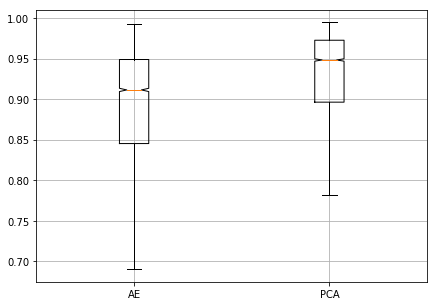

PCA 3.2165439846404884
AE 10.266825445211872


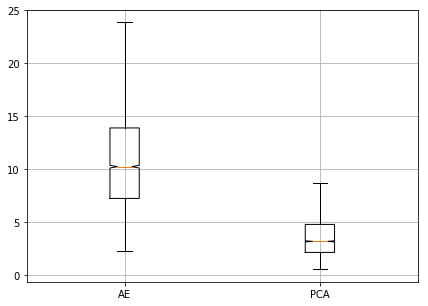

In [125]:
class lstm_autoencoder4(nn.Module):
    def __init__(self, input_size, batch_size, embedding_size):
        super(lstm_autoencoder4, self).__init__()
        if input_size%batch_size != 0:
            print('Input size dimensions not divisible by sequence length')
            return None
        self.activation_layer = nn.ELU()
        
        hid = 20
        
        first_lin_size = hid*input_size
        
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=hid, num_layers=2)
        self.lin1 = nn.Linear(first_lin_size, embedding_size)
        
        self.lin2 = nn.Linear(embedding_size, first_lin_size)
        self.lin3 = nn.Linear(first_lin_size, input_size)
    
    def forward(self, x, hidden=None):
        out, _ = self.lstm1(x, hidden)
        out = self.flatten_input(out)
        enc = self.lin1(out)
        out = self.lin2(enc)
        out = self.activation_layer(out)
        dec = self.lin3(out)
        return enc, dec
    
    def flatten_input(self, data):
        data = data.view(-1)
        return data

# Training the AE for encoder1

# Training for 4 embeddings

epoch_range = 5000
batch_size = 300
learning_rate = 0.00001
min_batch = 1

# embedding_size = 4

# ae_14 = lstm_autoencoder3(length, min_batch, embedding_size).cuda()
# ae_14.apply(init_weights)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     ae_14.parameters(), lr=learning_rate, weight_decay=0.001)

# enc, out, losses_14 = train_ae(ae_14, electrode_data_train, criterion, optimizer, epoch_range, batch_size, min_batch)

# Training for 2 embeddings

embedding_size = 2

ae_01 = lstm_autoencoder4(length, min_batch, embedding_size).cuda()
ae_01.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_01.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_01 = train_ae(ae_01, electrode_data_train, criterion, optimizer, epoch_range, batch_size, min_batch)

# Saving relevant files

# Saving Losses
# np.save('models/lstm_models/losses_1_4', np.array(losses_14))
np.save('models/lstm_models/losses_2_2', np.array(losses_01))


# Saving Models
# torch.save(ae_14, 'models/lstm_models/ae_1_4.pt') #Saving the autoencoder model
torch.save(ae_01, 'models/lstm_models/ae_2_2.pt') #Saving the autoencoder model

ae_1 = torch.load('models/lstm_models/ae_2_2.pt', map_location=lambda storage, loc: storage)
#ae_2 = torch.load('models/lstm_models/ae_1_4.pt', map_location=lambda storage, loc: storage)

_, out_ae = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'AE': out_ae, 'PCA': out_pca}
find_correlation_coeff(d)

pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse})

## Simple LSTM2 - LSTM2

In [114]:
class lstm_autoencoder2(nn.Module):
    def __init__(self, input_size, batch_size, embedding_size):
        super(lstm_autoencoder2, self).__init__()
        if input_size%batch_size != 0:
            print('Input size dimensions not divisible by sequence length')
            return None
        self.activation_layer = nn.ELU()
        
        self.hid = 20
        self.batch_size = batch_size
        
        first_lin_size = self.hid*input_size
        
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=self.hid, num_layers=2)
        self.lin1 = nn.Linear(first_lin_size, embedding_size)
        
        self.lin2 = nn.Linear(embedding_size, first_lin_size)
        self.lstm2 = nn.LSTM(input_size=self.hid, hidden_size=1, num_layers=2)
        
        self.lin3 = nn.Linear(51, 51)
    
    def forward(self, x, hidden=None):
        out, _ = self.lstm1(x, hidden)
        out = self.flatten_input(out)
        enc = self.lin1(out)
        out = self.activation_layer(enc)
        out = self.lin2(out)
        out = self.activation_layer(out)
        out = self.serialise_input_dec(out)
        out, _ = self.lstm2(out)
        out = self.flatten_input(out)
        dec = self.lin3(out)
        return enc, dec

    
    def serialise_input_dec(self, data):
        data = data.view(-1, self.batch_size, self.hid)
        return data
    
    def flatten_input(self, data):
        data = data.view(-1)
        return data

In [115]:
# Training the AE for encoder4

# Training for 4 embeddings

epoch_range = 5000
batch_size = 300
learning_rate = 0.0001
min_batch = 1

# embedding_size = 4

# ae_44 = lstm_autoencoder2(length, min_batch, embedding_size).cuda()
# ae_44.apply(init_weights)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     ae_44.parameters(), lr=learning_rate, weight_decay=0.001)

# enc, out, losses_44 = train_ae(ae_44, electrode_data_train, criterion, optimizer, epoch_range, batch_size, min_batch)

# Training for 2 embeddings

embedding_size = 2

ae_42 = lstm_autoencoder2(length, min_batch, embedding_size).cuda()
ae_42.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_42.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_42 = train_ae(ae_42, electrode_data_train, criterion, optimizer, epoch_range, batch_size, min_batch)

# Saving relevant files

# Saving Losses
#np.save('models/lstm_models/losses_4_4', np.array(losses_44))
np.save('models/lstm_models/losses_4_2', np.array(losses_42))


# Saving Models
#torch.save(ae_44, 'models/lstm_models/ae_4_4.pt') #Saving the autoencoder model
torch.save(ae_42, 'models/lstm_models/ae_4_2.pt') #Saving the autoencoder model

TOTAL PARAMETERS FOR MODEL: 13062
epoch [1/5000], loss:298.78186035, avg:1423.92907715
epoch [11/5000], loss:1458.83715820, avg:1132.77478027
epoch [21/5000], loss:198.86093140, avg:819.25799561
epoch [31/5000], loss:1037.18786621, avg:611.67987061
epoch [41/5000], loss:1193.70581055, avg:443.03964233
epoch [51/5000], loss:140.38410950, avg:376.37689209
epoch [61/5000], loss:364.49575806, avg:389.80053711
epoch [71/5000], loss:222.89648438, avg:650.12084961
epoch [81/5000], loss:160.07043457, avg:268.49038696
epoch [91/5000], loss:100.35933685, avg:231.03735352
epoch [101/5000], loss:370.30557251, avg:207.13032532
epoch [111/5000], loss:178.73300171, avg:212.64314270
epoch [121/5000], loss:221.61874390, avg:179.73031616
epoch [131/5000], loss:78.33401489, avg:179.81935120
epoch [141/5000], loss:364.10607910, avg:349.23184204
epoch [151/5000], loss:417.99191284, avg:195.87135315
epoch [161/5000], loss:257.69671631, avg:204.75968933
epoch [171/5000], loss:356.73703003, avg:304.59667969
e

epoch [1521/5000], loss:81.98970795, avg:135.90570068
epoch [1531/5000], loss:172.71725464, avg:141.69786072
epoch [1541/5000], loss:166.32957458, avg:130.08409119
epoch [1551/5000], loss:56.07147217, avg:118.87038422
epoch [1561/5000], loss:112.86142731, avg:141.21891785
epoch [1571/5000], loss:52.54292679, avg:206.39863586
epoch [1581/5000], loss:77.09741211, avg:148.64532471
epoch [1591/5000], loss:63.16601181, avg:151.79644775
epoch [1601/5000], loss:103.98962402, avg:90.78797150
epoch [1611/5000], loss:69.91865540, avg:83.57255554
epoch [1621/5000], loss:129.62236023, avg:164.27024841
epoch [1631/5000], loss:198.93531799, avg:147.79759216
epoch [1641/5000], loss:499.03710938, avg:177.21711731
epoch [1651/5000], loss:79.32355499, avg:116.28588104
epoch [1661/5000], loss:100.68794250, avg:157.79011536
epoch [1671/5000], loss:73.10760498, avg:128.23429871
epoch [1681/5000], loss:65.81381989, avg:191.93278503
epoch [1691/5000], loss:162.54731750, avg:98.11830902
epoch [1701/5000], los

epoch [3031/5000], loss:91.44890594, avg:94.51351166
epoch [3041/5000], loss:142.50508118, avg:120.31190491
epoch [3051/5000], loss:129.51121521, avg:127.45949554
epoch [3061/5000], loss:129.55416870, avg:145.73826599
epoch [3071/5000], loss:88.36613464, avg:139.47525024
epoch [3081/5000], loss:237.07682800, avg:131.90734863
epoch [3091/5000], loss:59.33288956, avg:131.35845947
epoch [3101/5000], loss:122.54777527, avg:148.70982361
epoch [3111/5000], loss:72.53616333, avg:260.29867554
epoch [3121/5000], loss:53.40175629, avg:114.91843414
epoch [3131/5000], loss:111.76881409, avg:166.37536621
epoch [3141/5000], loss:141.89523315, avg:112.48827362
epoch [3151/5000], loss:66.81466675, avg:130.62197876
epoch [3161/5000], loss:73.15494537, avg:101.02104950
epoch [3171/5000], loss:66.73152161, avg:240.26528931
epoch [3181/5000], loss:181.21418762, avg:128.11964417
epoch [3191/5000], loss:108.40318298, avg:174.33757019
epoch [3201/5000], loss:46.47578049, avg:101.67982483
epoch [3211/5000], l

epoch [4541/5000], loss:106.68434143, avg:102.36328125
epoch [4551/5000], loss:129.20300293, avg:154.42123413
epoch [4561/5000], loss:66.25774384, avg:142.75312805
epoch [4571/5000], loss:50.32435608, avg:80.78814697
epoch [4581/5000], loss:882.06018066, avg:169.45512390
epoch [4591/5000], loss:97.24854279, avg:81.37066650
epoch [4601/5000], loss:112.93535614, avg:80.59759521
epoch [4611/5000], loss:848.33593750, avg:169.76518250
epoch [4621/5000], loss:74.52259827, avg:142.02030945
epoch [4631/5000], loss:97.13191223, avg:152.00556946
epoch [4641/5000], loss:90.48485565, avg:127.46678925
epoch [4651/5000], loss:100.12896729, avg:130.83549500
epoch [4661/5000], loss:63.92594528, avg:339.98464966
epoch [4671/5000], loss:141.19003296, avg:163.72825623
epoch [4681/5000], loss:126.93978119, avg:144.45188904
epoch [4691/5000], loss:54.19490051, avg:246.28025818
epoch [4701/5000], loss:63.74725723, avg:110.45102692
epoch [4711/5000], loss:176.02593994, avg:154.14060974
epoch [4721/5000], los

In [120]:
ae_1 = torch.load('models/lstm_models/ae_4_2.pt', map_location=lambda storage, loc: storage)
#ae_2 = torch.load('models/lstm_models/ae_4_4.pt', map_location=lambda storage, loc: storage)

AE 0.946140206188737
PCA 0.9483949747235509


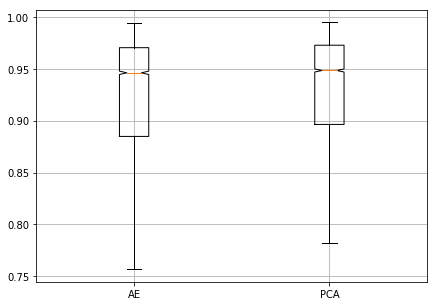

In [121]:
_, out_ae = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'AE': out_ae, 'PCA': out_pca}
find_correlation_coeff(d)

PCA 3.2165439846404533
AE 4.052983914482795


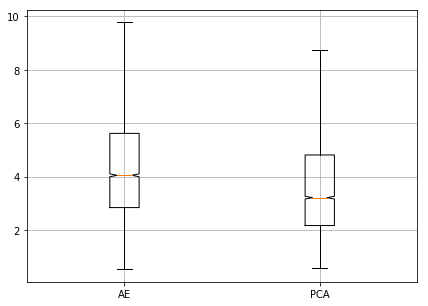

In [124]:
pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse})

# LSTM1 - LSTM1

TOTAL PARAMETERS FOR MODEL: 9686
epoch [1/5000], loss:1287.76098633, avg:1278.70251465
epoch [11/5000], loss:345.65710449, avg:1289.47167969
epoch [21/5000], loss:555.56982422, avg:808.37481689
epoch [31/5000], loss:210.95832825, avg:408.41293335
epoch [41/5000], loss:930.66687012, avg:478.48373413
epoch [51/5000], loss:200.13792419, avg:242.84675598
epoch [61/5000], loss:579.82641602, avg:428.82345581
epoch [71/5000], loss:111.80059052, avg:316.77023315
epoch [81/5000], loss:117.46432495, avg:205.40917969
epoch [91/5000], loss:116.94076538, avg:348.15560913
epoch [101/5000], loss:136.06292725, avg:206.42857361
epoch [111/5000], loss:125.99908447, avg:244.23875427
epoch [121/5000], loss:202.42646790, avg:300.51901245
epoch [131/5000], loss:107.94769287, avg:178.42033386
epoch [141/5000], loss:88.41080475, avg:113.67507172
epoch [151/5000], loss:430.07815552, avg:214.45262146
epoch [161/5000], loss:169.88346863, avg:185.71708679
epoch [171/5000], loss:2159.47753906, avg:395.88189697
epo

epoch [1521/5000], loss:80.19310760, avg:139.98843384
epoch [1531/5000], loss:157.48405457, avg:124.80831146
epoch [1541/5000], loss:104.96269989, avg:101.95987701
epoch [1551/5000], loss:2780.22387695, avg:363.35025024
epoch [1561/5000], loss:149.01365662, avg:110.07132721
epoch [1571/5000], loss:90.81166840, avg:113.78382874
epoch [1581/5000], loss:93.13058472, avg:108.52330780
epoch [1591/5000], loss:97.56427765, avg:99.91915131
epoch [1601/5000], loss:184.52365112, avg:95.93464661
epoch [1611/5000], loss:154.19822693, avg:93.59679413
epoch [1621/5000], loss:128.29945374, avg:210.51737976
epoch [1631/5000], loss:105.50576019, avg:100.13191986
epoch [1641/5000], loss:193.82543945, avg:94.60225677
epoch [1651/5000], loss:61.02580261, avg:122.53206635
epoch [1661/5000], loss:339.74523926, avg:120.84775543
epoch [1671/5000], loss:59.16324997, avg:119.26515198
epoch [1681/5000], loss:43.76950073, avg:157.43656921
epoch [1691/5000], loss:49.69651031, avg:111.51814270
epoch [1701/5000], lo

epoch [3031/5000], loss:208.93733215, avg:203.21794128
epoch [3041/5000], loss:75.72922516, avg:161.74186707
epoch [3051/5000], loss:155.97018433, avg:97.53448486
epoch [3061/5000], loss:179.51757812, avg:153.19218445
epoch [3071/5000], loss:119.59466553, avg:97.58452606
epoch [3081/5000], loss:187.85830688, avg:128.99797058
epoch [3091/5000], loss:129.59904480, avg:86.70061493
epoch [3101/5000], loss:107.47060394, avg:109.37223053
epoch [3111/5000], loss:53.14000702, avg:103.10888672
epoch [3121/5000], loss:86.79400635, avg:105.35408783
epoch [3131/5000], loss:127.37959290, avg:130.24038696
epoch [3141/5000], loss:127.86843109, avg:107.81729889
epoch [3151/5000], loss:127.96630096, avg:75.22509003
epoch [3161/5000], loss:47.20381546, avg:154.08172607
epoch [3171/5000], loss:104.95604706, avg:104.66845703
epoch [3181/5000], loss:66.72055817, avg:108.31896973
epoch [3191/5000], loss:213.73123169, avg:109.54412079
epoch [3201/5000], loss:385.65093994, avg:133.69650269
epoch [3211/5000], 

epoch [4541/5000], loss:89.15255737, avg:93.38878632
epoch [4551/5000], loss:182.54351807, avg:130.09858704
epoch [4561/5000], loss:80.19068146, avg:111.48227692
epoch [4571/5000], loss:232.55305481, avg:104.81697083
epoch [4581/5000], loss:56.09124756, avg:124.74135590
epoch [4591/5000], loss:241.23016357, avg:143.71577454
epoch [4601/5000], loss:60.39344025, avg:128.27862549
epoch [4611/5000], loss:71.51332855, avg:181.80709839
epoch [4621/5000], loss:132.10128784, avg:96.93804932
epoch [4631/5000], loss:126.77874756, avg:149.42338562
epoch [4641/5000], loss:94.73366547, avg:112.97248840
epoch [4651/5000], loss:91.53812408, avg:307.15374756
epoch [4661/5000], loss:120.23640442, avg:139.21482849
epoch [4671/5000], loss:41.29890442, avg:87.37358856
epoch [4681/5000], loss:59.01485062, avg:82.23476410
epoch [4691/5000], loss:49.96788025, avg:93.14740753
epoch [4701/5000], loss:74.77200317, avg:120.72959137
epoch [4711/5000], loss:150.56660461, avg:143.35113525
epoch [4721/5000], loss:61

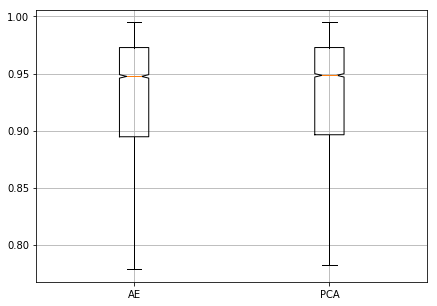

PCA 3.2165439846405746
AE 3.6262937361102665


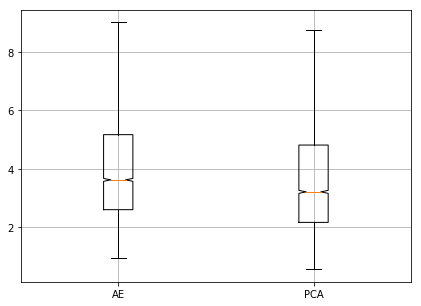

In [126]:
class lstm_autoencoder0(nn.Module):
    def __init__(self, input_size, batch_size, embedding_size):
        super(lstm_autoencoder0, self).__init__()
        if input_size%batch_size != 0:
            print('Input size dimensions not divisible by sequence length')
            return None
        self.activation_layer = nn.ELU()
        
        self.hid = 20
        self.batch_size = batch_size
        
        first_lin_size = self.hid*input_size
        
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=self.hid, num_layers=1)
        self.lin1 = nn.Linear(first_lin_size, embedding_size)
        
        self.lin2 = nn.Linear(embedding_size, first_lin_size)
        self.lstm2 = nn.LSTM(input_size=self.hid, hidden_size=1, num_layers=1)
        
        self.lin3 = nn.Linear(51, 51)
    
    def forward(self, x, hidden=None):
        out, _ = self.lstm1(x, hidden)
        out = self.flatten_input(out)
        enc = self.lin1(out)
        out = self.activation_layer(enc)
        out = self.lin2(out)
        out = self.activation_layer(out)
        out = self.serialise_input_dec(out)
        out, _ = self.lstm2(out)
        out = self.flatten_input(out)
        dec = self.lin3(out)
        return enc, dec

    
    def serialise_input_dec(self, data):
        data = data.view(-1, self.batch_size, self.hid)
        return data
    
    def flatten_input(self, data):
        data = data.view(-1)
        return data

# Training the AE for encoder4

# Training for 4 embeddings

epoch_range = 5000
batch_size = 300
learning_rate = 0.0001
min_batch = 1

# embedding_size = 4

# ae_44 = lstm_autoencoder2(length, min_batch, embedding_size).cuda()
# ae_44.apply(init_weights)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     ae_44.parameters(), lr=learning_rate, weight_decay=0.001)

# enc, out, losses_44 = train_ae(ae_44, electrode_data_train, criterion, optimizer, epoch_range, batch_size, min_batch)

# Training for 2 embeddings

embedding_size = 2

ae_02 = lstm_autoencoder0(length, min_batch, embedding_size).cuda()
ae_02.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_02.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_02 = train_ae(ae_02, electrode_data_train, criterion, optimizer, epoch_range, batch_size, min_batch)

# Saving relevant files

# Saving Losses
#np.save('models/lstm_models/losses_4_4', np.array(losses_44))
np.save('models/lstm_models/losses_11_2', np.array(losses_02))


# Saving Models
#torch.save(ae_44, 'models/lstm_models/ae_4_4.pt') #Saving the autoencoder model
torch.save(ae_02, 'models/lstm_models/ae_11_2.pt') #Saving the autoencoder model

ae_1 = torch.load('models/lstm_models/ae_11_2.pt', map_location=lambda storage, loc: storage)
#ae_2 = torch.load('models/lstm_models/ae_4_4.pt', map_location=lambda storage, loc: storage)

_, out_ae = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'AE': out_ae, 'PCA': out_pca}
find_correlation_coeff(d)

pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse})

In [ ]:
pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
out_base = np.zeros((electrode_data_test.shape[0], 51))
for i in range(51):
    out_base[:, i] = np.mean(electrode_data_test[:, i])
baseline = find_scaled_mse(electrode_data_test, out_base, 'Baseline')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse, 'Baseline': baseline})

In [ ]:
def relative_improvement(ae_data, pca_data, baseline):
    ae_improv = np.abs((np.median(baseline) - np.median(ae_data))/np.median(baseline))
    ae_improv *= 100

    pca_improv = np.abs((np.median(baseline) - np.median(pca_data))/np.median(baseline))
    pca_improv *= 100

    print("Baseline Value: ", np.median(baseline))
    print("AE Value: ", np.median(ae_data))
    print("PCA Value: ", np.median(pca_data))
    print('\n AE improvement: ', ae_improv)
    print('PCA improvement: ', pca_improv)

In [ ]:
# Correlation Coefficient Improvement

d = {'AE': out_ae, 'PCA': out_pca, 'Baseline': comp_pca(0)}
meds = find_correlation_coeff(d, plot=False)

print(meds)
relative_improvement(meds[0][1], meds[1][1], meds[2][1])

In [ ]:
# MSE Improvement
relative_improvement(ae_mse, pca_mse, baseline)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5

# initialize the hidden state.
hidden = (torch.randn(1, 1, 3),
          torch.randn(1, 1, 3))
for i in inputs:
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)

# alternatively, we can do the entire sequence all at once.
# the first value returned by LSTM is all of the hidden states throughout
# the sequence. the second is just the most recent hidden state
# (compare the last slice of "out" with "hidden" below, they are the same)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence
# "hidden" will allow you to continue the sequence and backpropagate,
# by passing it as an argument  to the lstm at a later time
# Add the extra 2nd dimension
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # clean out hidden state
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)

In [ ]:
inputs = electrode_data_test[0, :]
inputs = torch.from_numpy(inputs).float()
batch_size = 3
inputs = inputs.view(-1, batch_size, 1)
print(inputs.shape)